In [1]:
# import stuff
%load_ext autoreload
%autoreload 2
%matplotlib inline

from random import randint

import numpy as np
import torch

In [2]:
device_num = torch.cuda.current_device()
print(device_num, torch.cuda.device(0), torch.cuda.device_count(), torch.cuda.get_device_name(0))

0 <torch.cuda.device object at 0x7f7ae1383e80> 1 Tesla K80


## Load model

In [3]:
from models import InferSent
MODEL_PATH =  './infersent2.pkl'  # location was different
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': 1}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))
model.is_cuda()

0 <torch.cuda.device object at 0x7f7aae0de780> 1 Tesla K80


False

In [4]:
W2V_PATH = '../dataset/GloVe/glove.840B.300d.txt'
model.set_w2v_path(W2V_PATH)

In [5]:
import time
time_start = time.time()
model.build_vocab_k_words(K=100000)
print(time.time() - time_start)

Vocab size : 100000
8.404623031616211


## Load sentences

In [6]:
# Load some sentences
sentences = []
with open('samples.txt') as f:
    for line in f:
        sentences.append(line.strip())
print(len(sentences))

1000


In [7]:
sentences[:5]

['Everyone really likes the newest benefits',
 'The Government Executive articles housed on the website are not able to be searched .',
 'I like him for the most part , but would still enjoy seeing someone beat him .',
 'My favorite restaurants are always at least a hundred miles away from my house .',
 'I know exactly .']

## Encode sentences

In [8]:
# gpu mode : ~1000 sentences/s
# cpu mode : ~75 sentences/s

In [9]:
print(torch.rand(3,3).cuda()) 

tensor([[0.8226, 0.9993, 0.3155],
        [0.1798, 0.4472, 0.7367],
        [0.0182, 0.5049, 0.3021]], device='cuda:0')


In [10]:
model.is_cuda()

False

In [11]:
time_start = time.time()
embeddings = model.encode(sentences, bsize=128, tokenize=False, verbose=True)
print(time.time() - time_start)
print('nb sentences encoded : {0}'.format(len(embeddings)))

Nb words kept : 13031/13210 (98.6%)
Speed : 58.8 sentences/s (cpu mode, bsize=128)
17.017409086227417
nb sentences encoded : 1000


## Visualization

In [12]:
np.linalg.norm(model.encode(['the cat eats.']))

4.573626

In [13]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [14]:
import matplotlib.pyplot as plt
def cosine_graph(u, v):
    plt.figure(figsize=(15,4))
    plt.plot(u,lw=0.3)
    plt.plot(v,lw=0.3)
    plt.plot(u-v,lw=0.6)
    plt.show()
    return cosine(u, v)

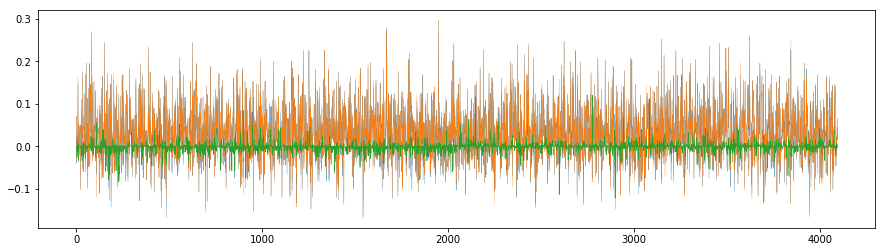

0.98855555

In [15]:
cosine_graph(model.encode(['This is good.'])[0], model.encode(['This is better.'])[0])

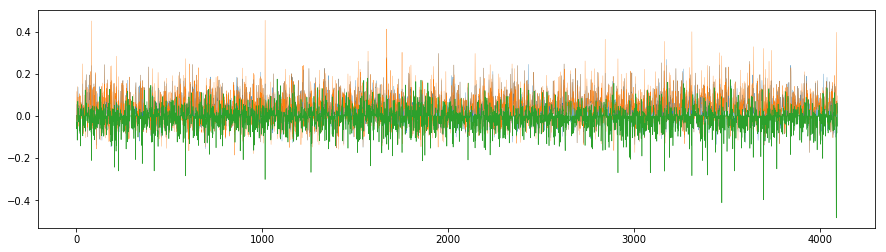

0.79119164

In [16]:
cosine_graph(model.encode(['The cat meows.'])[0], model.encode(['Communism shall prevail.'])[0])

In [17]:
def compare_InferSent(a,b):
    return cosine(model.encode([a])[0], model.encode([b])[0])

In [18]:
sentences = ["Obama is born in Kenya.",
             "Obama was not born in Kenya.",
             "Obama was delivered in Kenya.",
             "The place of birth of Obama in Kenya.",
             "Obama was born in New York.",
             "Obama has visited Kenya's president's birthplace.",
             "Obama is a Muslim.",
             "Obama is a Muslim and was born in Kenya.",
             "Obama is trying to take our guns away.",
             "Obama was born in Kenya and is going to take our guns away.",
             "I like ice cream.",
             "Lee Kwan Yew was a dictator."]

In [19]:
sent_vect = model.encode(sentences)  
# can be sped up with GPU, I could not connect to GPU this time, neither we expect to use GPU in production :/
print(np.shape(sent_vect))

(12, 4096)


In [20]:
value_mesh = np.zeros((len(sentences), len(sentences)))

import numpy as np
for i,_ in enumerate(sentences):
    for j,_ in enumerate(sentences): 
        value_mesh[i,j] = cosine(sent_vect[i], sent_vect[j])

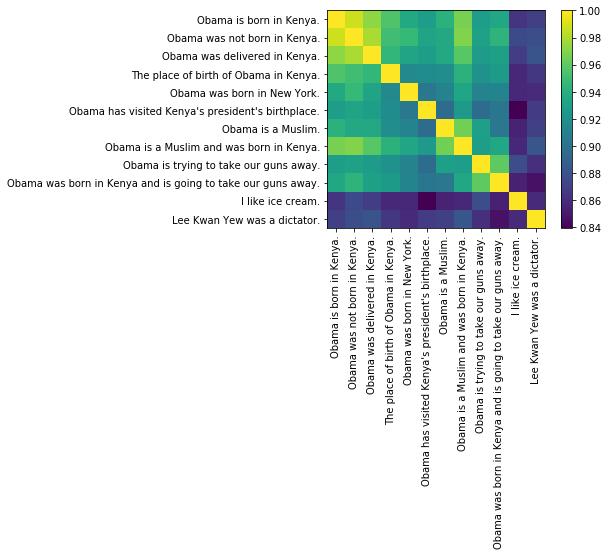

In [21]:
# plt.figure(figsize=(12,12))
plt.imshow(value_mesh)
plt.yticks(np.arange(len(sentences)), sentences)
plt.xticks(np.arange(len(sentences)), sentences, rotation='vertical')
plt.colorbar()

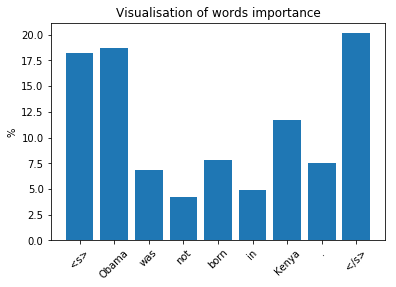

In [22]:
idx = randint(0, len(sentences))
_, _ = model.visualize(sentences[idx])

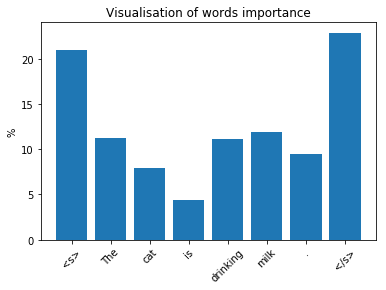

In [23]:
my_sent = 'The cat is drinking milk.'
_, _ = model.visualize(my_sent)

Vocab size : 500000


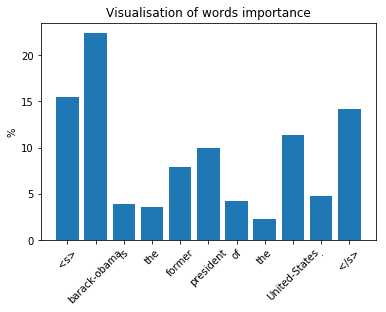

In [24]:
model.build_vocab_k_words(500000) # getting 500K words vocab
my_sent = 'barack-obama is the former president of the United-States.'
_, _ = model.visualize(my_sent)